In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
!pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


LOAD DỮ LIỆU

In [ ]:
df = pd.read_csv("train.csv")
print(f"Data shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

Data shape: (1460, 81)
Columns: 81


In [15]:
location_lot_features = [
    "MSZoning", "Neighborhood", "Condition1", "Condition2",
    "LotArea", "LotFrontage", "LotShape", "LandContour",
    "LandSlope", "LotConfig", "Street", "Alley", "Utilities"
]

size_interior_features = [
    "BedroomAbvGr", "TotRmsAbvGrd", "1stFlrSF", "2ndFlrSF",
    "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath",
    "GrLivArea", "TotalBsmtSF", "LowQualFinSF",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
    "GarageArea", "GarageCars", "LowQualFinSF",
    "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "ScreenPorch", "3SsnPorch"
]

quality_condition_features = [
    "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd",
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
    "KitchenQual", "FireplaceQu", "HeatingQC",
    "GarageQual", "GarageCond", "MasVnrType", "MasVnrArea"
]

amenities_features = [
    "Fence", "MiscFeature", "MiscVal",
    "PoolArea", "PoolQC", "SaleType", "SaleCondition",
    "MoSold", "YrSold"
]

print("\nFeature groups loaded:")
print(f"Location & Lot:     {len(location_lot_features)}")
print(f"Size & Interior:    {len(size_interior_features)}")
print(f"Quality & Condition:{len(quality_condition_features)}")
print(f"Amenities/Sale:     {len(amenities_features)}")


Feature groups loaded:
Location & Lot:     13
Size & Interior:    22
Quality & Condition:15
Amenities/Sale:     9


LỰA CHỌN ĐẶC TRƯNG CỦA MỖI NHÓM

=== KẾT QUẢ TUYỂN CHỌN THEO NGƯỠNG TƯƠNG QUAN (|corr| ≥ 0.6) ===
NHÓM                           | FEATURE              | CORR      
----------------------------------------------------------------------
1. Location & Lot              | Không có feature đạt ngưỡng
2. Size & Interior             | GrLivArea            | 0.7086
2. Size & Interior             | GarageCars           | 0.6404
2. Size & Interior             | GarageArea           | 0.6234
2. Size & Interior             | TotalBsmtSF          | 0.6136
2. Size & Interior             | 1stFlrSF             | 0.6059
3. Quality & Condition         | OverallQual          | 0.7910
4. Amenities                   | Không có feature đạt ngưỡng
----------------------------------------------------------------------
Danh sách feature: ['GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'OverallQual']


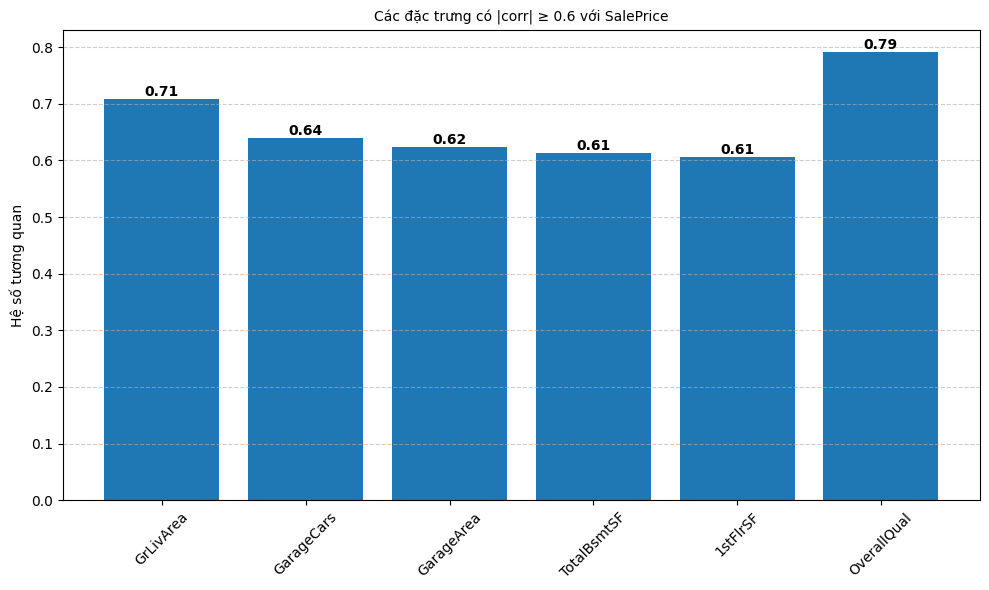

In [16]:
# 1. Load dữ liệu
df = pd.read_csv('train.csv')
numeric_df = df.select_dtypes(include=[np.number])

# 2. Tính tương quan với SalePrice
correlations = numeric_df.corr()['SalePrice'].sort_values(ascending=False)

# 3. Định nghĩa nhóm
teacher_groups = {
    "1. Location & Lot": location_lot_features, 
    "2. Size & Interior": size_interior_features,
    "3. Quality & Condition": quality_condition_features,
    "4. Amenities": amenities_features
}

# 4. Ngưỡng tương quan
CORR_THRESHOLD = 0.6

print("=== KẾT QUẢ TUYỂN CHỌN THEO NGƯỠNG TƯƠNG QUAN (|corr| ≥ 0.6) ===")
print(f"{'NHÓM':<30} | {'FEATURE':<20} | {'CORR':<10}")
print("-" * 70)

final_features = []
final_corr_values = []

for group_name, candidates in teacher_groups.items():
    valid_candidates = [c for c in candidates if c in correlations.index]

    selected = correlations[valid_candidates][
        correlations[valid_candidates].abs() >= CORR_THRESHOLD
    ]

    if selected.empty:
        print(f"{group_name:<30} | Không có feature đạt ngưỡng")
        continue

    for feature, corr_value in selected.sort_values(ascending=False).items():
        print(f"{group_name:<30} | {feature:<20} | {corr_value:.4f}")
        final_features.append(feature)
        final_corr_values.append(corr_value)

print("-" * 70)
print(f"Danh sách feature: {final_features}")

# 5. Vẽ biểu đồ tương quan
plt.figure(figsize=(10, 6))
bars = plt.bar(final_features, final_corr_values)

plt.title('Các đặc trưng có |corr| ≥ 0.6 với SalePrice', fontsize=10)
plt.ylabel('Hệ số tương quan')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval,
        round(yval, 2),
        ha='center',
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

KHỞI TẠO DATASET


=== THÔNG TIN ĐƠN VỊ ĐO TIME SERIES ===
- Tần suất dữ liệu: Monthly (MS)
- Target: SalePrice (y) | Đơn vị: USD | Tổng hợp: median
- Regressor & phương pháp tổng hợp:
   • GrLivArea: mean/month
   • GarageCars: mean/month
   • GarageArea: mean/month
   • TotalBsmtSF: mean/month
   • 1stFlrSF: mean/month
   • OverallQual: mean/month


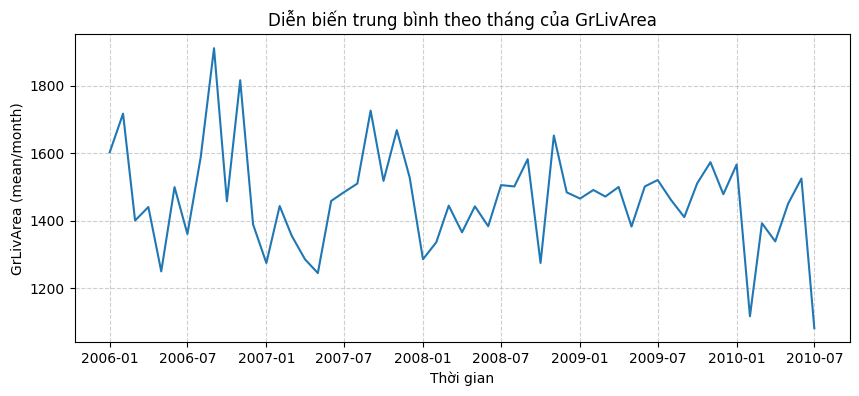

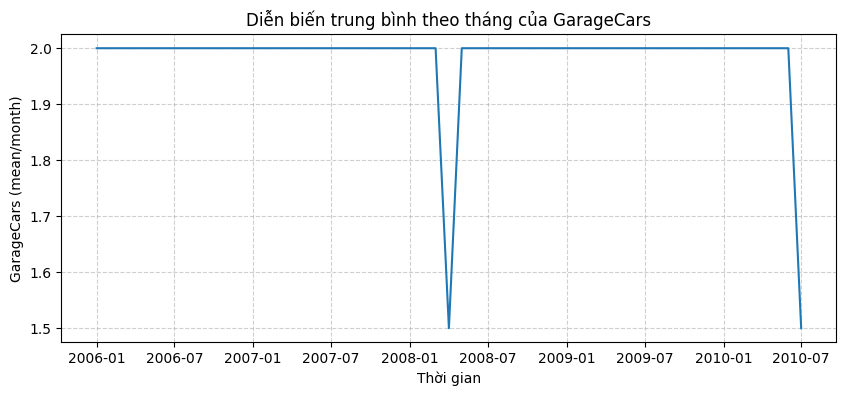

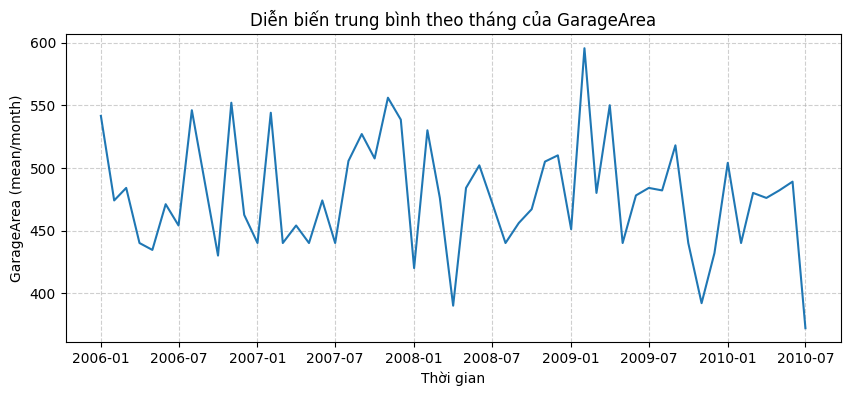

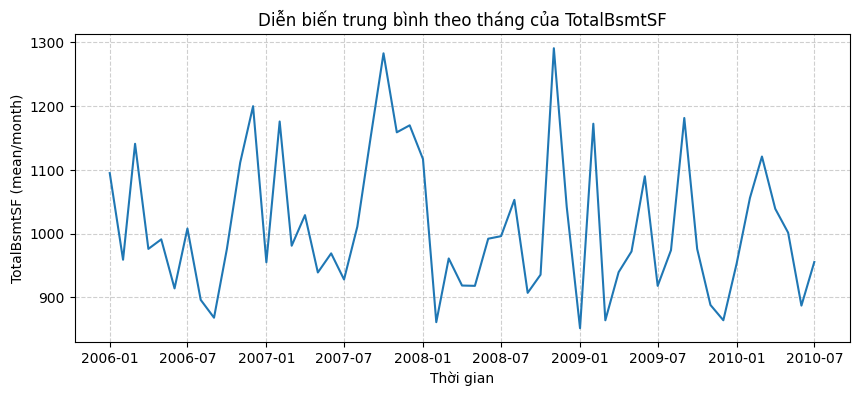

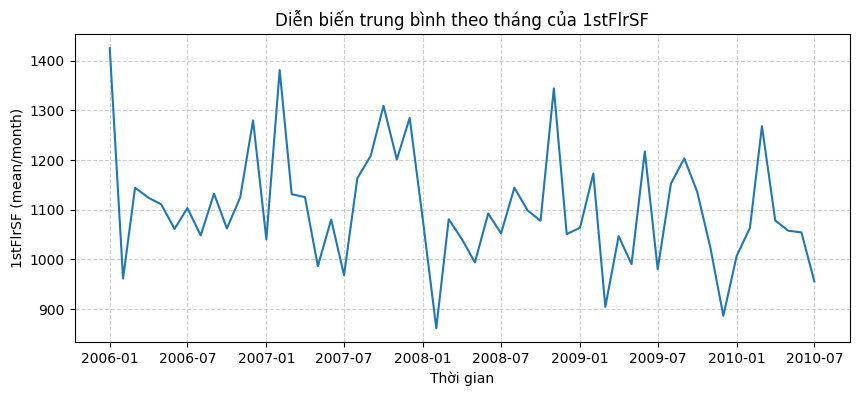

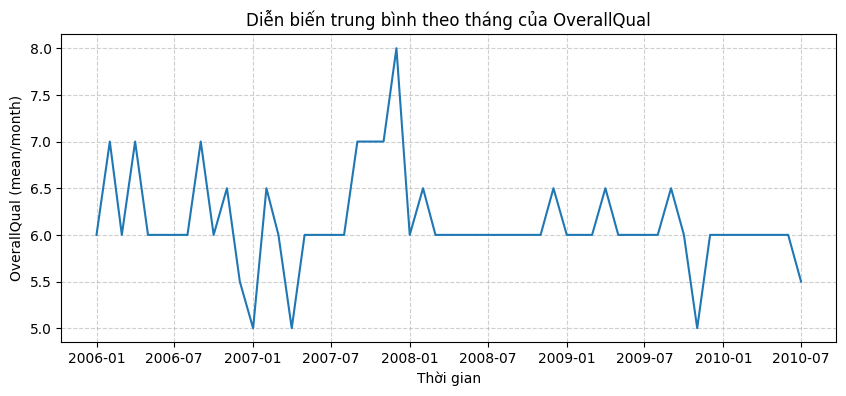

In [17]:
def create_prophet_dataset(file_path, regressors):
    df = pd.read_csv(file_path)

    df['ds'] = pd.to_datetime(
        df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01'
    )

    # Lọc regressor hợp lệ
    valid_regressors = [
        r for r in regressors
        if r in df.columns and pd.api.types.is_numeric_dtype(df[r])
    ]

    selected_cols = ['ds', 'SalePrice'] + valid_regressors
    df_slim = df[selected_cols].copy()

    # Phương pháp tổng hợp
    agg_dict = {'SalePrice': 'median'}
    regressor_agg = {col: 'median' for col in valid_regressors}
    agg_dict.update(regressor_agg)

    df_ts = df_slim.groupby('ds').agg(agg_dict).reset_index()

    # Tạo full range theo đơn vị tháng
    full_range = pd.date_range(df_ts['ds'].min(), df_ts['ds'].max(), freq='MS')
    df_ts = df_ts.set_index('ds').reindex(full_range).interpolate(method='linear')
    df_ts = df_ts.reset_index().rename(columns={'index': 'ds', 'SalePrice': 'y'})

    metadata = {
        "frequency": "Monthly (MS)",
        "target": {"name": "SalePrice (y)", "unit": "USD", "agg": "median"},
        "regressors": {col: "mean/month" for col in valid_regressors}
    }

    return df_ts, valid_regressors, metadata

# --- THỰC THI ---
df_prophet, prophet_regressors, meta = create_prophet_dataset('train.csv', final_features)

print("\n=== THÔNG TIN ĐƠN VỊ ĐO TIME SERIES ===")
print(f"- Tần suất dữ liệu: {meta['frequency']}")
print(f"- Target: {meta['target']['name']} | Đơn vị: {meta['target']['unit']} | Tổng hợp: {meta['target']['agg']}")
print("- Regressor & phương pháp tổng hợp:")
for k,v in meta['regressors'].items():
    print(f"   • {k}: {v}")

# VẼ BIỂU ĐỒ KIỂM TRA ---
for col in prophet_regressors:
    plt.figure(figsize=(10,4))
    sns.lineplot(data=df_prophet, x='ds', y=col)
    plt.title(f'Diễn biến trung bình theo tháng của {col}')
    plt.xlabel('Thời gian')
    plt.ylabel(f'{col} (mean/month)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Rolling Window Cross-Validation (thay vì CHE ĐI KẾT QUẢ CỦA NĂM 2010)

Tập Train và tập Test SẼ THAY ĐỔI LIÊN TỤC qua mỗi vòng lặp (chính xác là 24 tháng NGAY TRƯỚC cái tháng nó dự báo)

In [18]:
results = []
train_months = 24   # Số tháng train
test_months = 1    # Số tháng test
step = 1

for start in range(0, len(df_prophet) - train_months - test_months + 1, step):
    train_ts = df_prophet.iloc[start:start + train_months]
    test_ts  = df_prophet.iloc[start + train_months:start + train_months + test_months]

    m = Prophet(
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    # m.add_seasonality(name='monthly', period=12, fourier_order=8)

    for r in prophet_regressors:
        m.add_regressor(r)

    m.fit(train_ts, algorithm='LBFGS')

    future = test_ts.drop(columns=['y'])
    forecast = m.predict(future)

    # Lưu kết quả từng tháng
    for idx in range(test_months):
        y_true = test_ts['y'].values[idx]
        y_pred = forecast['yhat'].values[idx]

        results.append([
            test_ts['ds'].dt.strftime('%Y-%m').values[idx],
            y_true,
            y_pred,
            abs(y_pred - y_true),
            abs((y_pred - y_true)/y_true)*100
        ])

rolling_df = pd.DataFrame(results, columns=["Tháng","Thực tế","Dự báo","Lệch ($)","Lệch (%)"])
rolling_df['Lệch ($)'] = rolling_df['Lệch ($)'].astype(int)


# --- Tính metric ---
mae  = rolling_df['Lệch ($)'].mean()
rmse = np.sqrt(np.mean((rolling_df['Dự báo'] - rolling_df['Thực tế'])**2))
mape = rolling_df['Lệch (%)'].mean()

# --- Chuẩn hóa MAE & RMSE sang % ---
y_mean = rolling_df['Thực tế'].mean()
mae_pct  = mae  / y_mean * 100
rmse_pct = rmse / y_mean * 100
mape_pct = mape

# --- Chọn metric tốt nhất ---
metrics_pct = {
    "MAE": mae_pct,
    "RMSE": rmse_pct,
    "MAPE": mape_pct
}

best_metric_name = min(metrics_pct, key=metrics_pct.get)
best_metric_value = metrics_pct[best_metric_name]

# --- In kết quả ---
print(f"MAE trung bình:  {mae_pct:.2f}%")
print(f"RMSE trung bình: {rmse_pct:.2f}%")
print(f"MAPE trung bình: {mape_pct:.2f}%")

print("\n===== ĐÁNH GIÁ HIỆU SUẤT TỰ ĐỘNG CHỌN METRIC =====")
print(f"Độ đo tốt nhất: {best_metric_name} = {best_metric_value:.2f}%")

# --- Xếp loại dựa trên metric tốt nhất ---
def rating_func(value):
    if value < 10:
        return "Xuất sắc"
    elif value < 20:
        return "Ổn"
    elif value < 30:
        return "Trung bình"
    else:
        return "Cần cải thiện"

rating = rating_func(best_metric_value)
print(f"Đánh giá chung dựa trên {best_metric_name}: {rating}")

print("\n================ CHI TIẾT DỰ BÁO MỖI THÁNG ================")
print(rolling_df)


01:23:25 - cmdstanpy - INFO - Chain [1] start processing
01:23:25 - cmdstanpy - INFO - Chain [1] done processing
01:23:25 - cmdstanpy - INFO - Chain [1] start processing
01:23:25 - cmdstanpy - INFO - Chain [1] done processing
01:23:26 - cmdstanpy - INFO - Chain [1] start processing
01:23:26 - cmdstanpy - INFO - Chain [1] done processing
01:23:26 - cmdstanpy - INFO - Chain [1] start processing
01:23:26 - cmdstanpy - INFO - Chain [1] done processing
01:23:26 - cmdstanpy - INFO - Chain [1] start processing
01:23:26 - cmdstanpy - INFO - Chain [1] done processing
01:23:26 - cmdstanpy - INFO - Chain [1] start processing
01:23:26 - cmdstanpy - INFO - Chain [1] done processing
01:23:26 - cmdstanpy - INFO - Chain [1] start processing
01:23:26 - cmdstanpy - INFO - Chain [1] done processing
01:23:26 - cmdstanpy - INFO - Chain [1] start processing
01:23:26 - cmdstanpy - INFO - Chain [1] done processing
01:23:27 - cmdstanpy - INFO - Chain [1] start processing
01:23:27 - cmdstanpy - INFO - Chain [1]

MAE trung bình:  16.08%
RMSE trung bình: 21.93%
MAPE trung bình: 16.53%

===== ĐÁNH GIÁ HIỆU SUẤT TỰ ĐỘNG CHỌN METRIC =====
Độ đo tốt nhất: MAE = 16.08%
Đánh giá chung dựa trên MAE: Ổn

================ CHI TIẾT DỰ BÁO MỖI THÁNG ================
      Tháng   Thực tế         Dự báo  Lệch ($)   Lệch (%)
0   2008-01  149000.0  128882.946923     20117  13.501378
1   2008-02  147500.0  133782.308454     13717   9.300130
2   2008-03  165500.0  176086.963235     10586   6.396957
3   2008-04  136625.0  128477.049253      8147   5.963733
4   2008-05  176750.0  198599.521770     21849  12.361823
5   2008-06  161000.0  146482.724894     14517   9.016941
6   2008-07  178400.0  160611.412835     17788   9.971181
7   2008-08  175000.0  175141.748749       141   0.080999
8   2008-09  172000.0  159533.153064     12466   7.248167
9   2008-10  150500.0  139339.254062     11160   7.415778
10  2008-11  173000.0  183239.552354     10239   5.918816
11  2008-12  169000.0  221927.118984     52927  31.317822


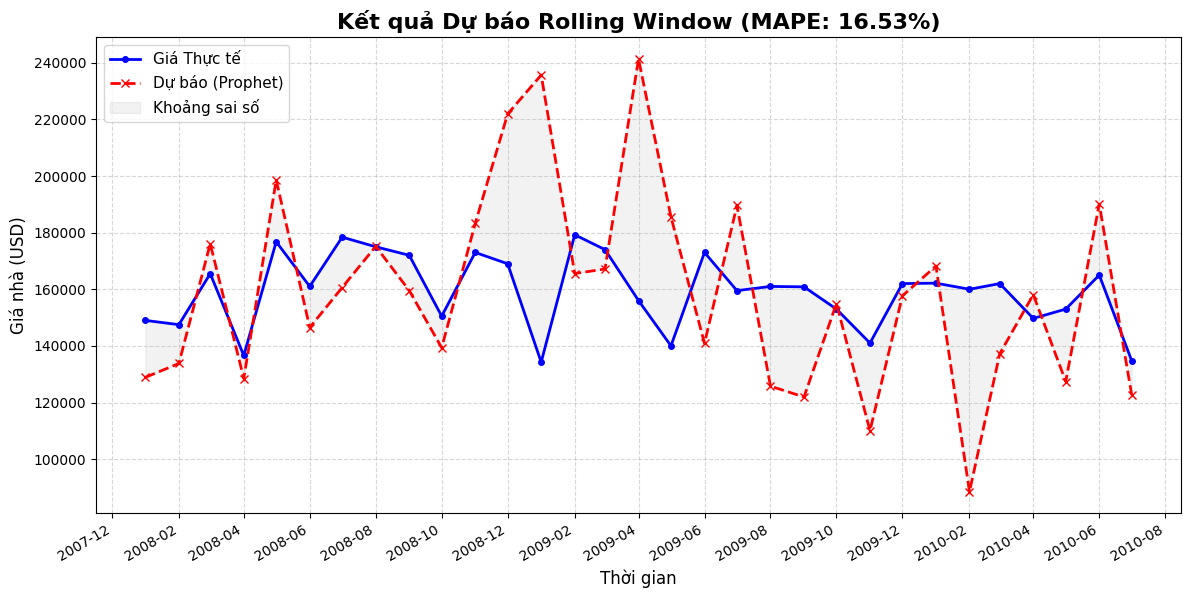

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Chuyển đổi cột 'Tháng' sang kiểu datetime để vẽ cho đẹp
rolling_df['Date'] = pd.to_datetime(rolling_df['Tháng'])
rolling_df = rolling_df.sort_values('Date')

plt.figure(figsize=(14, 7))

# Vẽ đường thực tế
plt.plot(rolling_df['Date'], rolling_df['Thực tế'], 
         label='Giá Thực tế', color='blue', linewidth=2, marker='o', markersize=4)

# Vẽ đường dự báo
plt.plot(rolling_df['Date'], rolling_df['Dự báo'], 
         label='Dự báo (Prophet)', color='red', linestyle='--', linewidth=2, marker='x')

# Tô màu vùng sai số
plt.fill_between(rolling_df['Date'], 
                 rolling_df['Thực tế'], 
                 rolling_df['Dự báo'], 
                 color='gray', alpha=0.1, label='Khoảng sai số')

plt.title(f'Kết quả Dự báo Rolling Window (MAPE: {mape_pct:.2f}%)', fontsize=16, fontweight='bold')
plt.ylabel('Giá nhà (USD)', fontsize=12)
plt.xlabel('Thời gian', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)

# Định dạng trục X hiển thị theo tháng-năm
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Cách 2 tháng hiện 1 lần
plt.gcf().autofmt_xdate() # Xoay nghiêng chữ ngày tháng

plt.show()

01:29:20 - cmdstanpy - INFO - Chain [1] start processing
01:29:20 - cmdstanpy - INFO - Chain [1] done processing


=== PHÂN TÍCH CÁC THÀNH PHẦN (TREND, SEASONALITY) ===


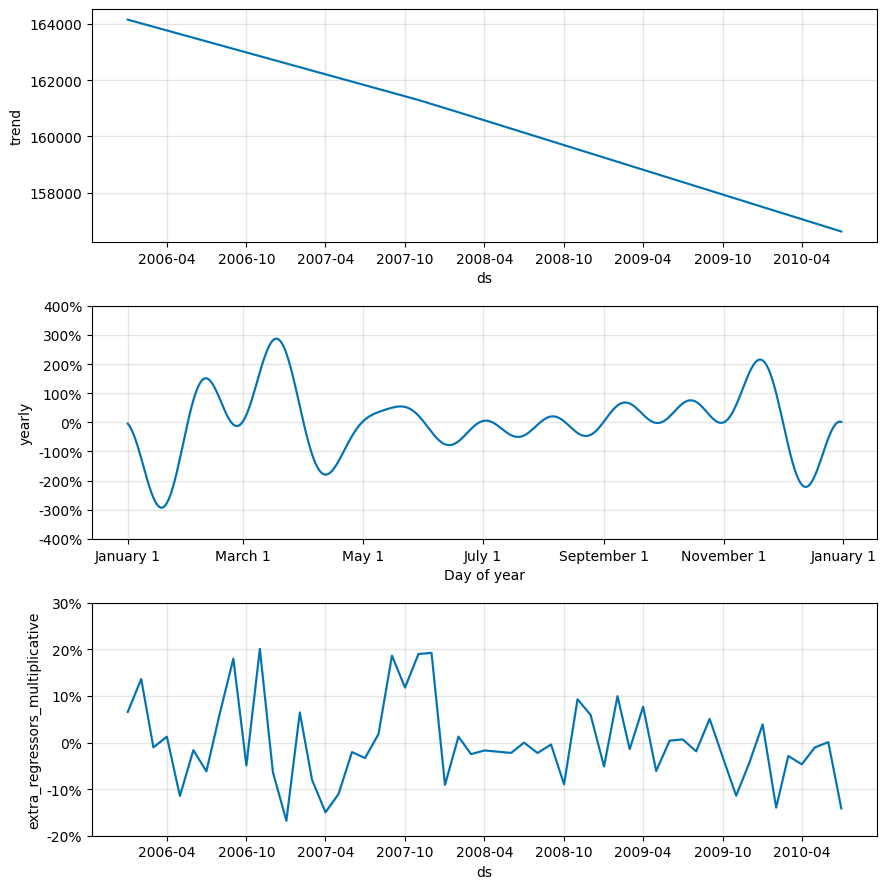

In [ ]:
# 1. Khởi tạo mô hình mới (Full data)
m_final = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

# 2. Add lại các Regressors (QUAN TRỌNG: Phải add y chang lúc train)
for r in prophet_regressors:
    m_final.add_regressor(r)

# 3. Fit trên TOÀN BỘ dữ liệu (không chia train/test nữa)
m_final.fit(df_prophet, algorithm='LBFGS')

# 4. Dự báo lại trên chính lịch sử để xem các thành phần
# (Lấy lại df_prophet bỏ cột y để làm đầu vào)
future_all = df_prophet.drop(columns=['y'])
forecast_final = m_final.predict(future_all)

# 5. Vẽ biểu đồ phân tích thành phần
print("=== PHÂN TÍCH CÁC THÀNH PHẦN (TREND, SEASONALITY) ===")
fig = m_final.plot_components(forecast_final)
plt.show()